# Multi-Objective Optimization Ax API
### Using the Service API
For Multi-objective optimization (MOO) in the `AxClient`, objectives are specified through the `ObjectiveProperties` dataclass.  An `ObjectiveProperties` requires a boolean `minimize`, and also accepts an optional floating point  `threshold`.  If a `threshold` is not specified, Ax will infer it through the use of heuristics.  If the user knows the region of interest (because they have specs or prior knowledge), then specifying the thresholds is preferable to inferring it. But if the user would need to guess, inferring is preferable.


To learn more about how to choose a threshold, see [Set Objective Thresholds to focus candidate generation in a region of interest](#Set-Objective-Thresholds-to-focus-candidate-generation-in-a-region-of-interest).  See the [Service API Tutorial](/tutorials/gpei_hartmann_service.html) for more infomation on running experiments with the Service API.

In [1]:
import torch
from ax.plot.pareto_frontier import plot_pareto_frontier
from ax.plot.pareto_utils import compute_posterior_pareto_frontier
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties

# Plotting imports and initialization
from ax.utils.notebook.plotting import init_notebook_plotting, render
from botorch.test_functions.multi_objective import BraninCurrin

init_notebook_plotting()

[INFO 05-02 22:35:08] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.


[INFO 05-02 22:35:08] ax.utils.notebook.plotting: Please see
    (https://ax.dev/tutorials/visualizations.html#Fix-for-plots-that-are-not-rendering)
    if visualizations are not rendering.


In [2]:
# Load our sample 2-objective problem
branin_currin = BraninCurrin(negate=True).to(
    dtype=torch.double,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
)

In [3]:
ax_client = AxClient()
ax_client.create_experiment(
    name="moo_experiment",
    parameters=[
        {
            "name": f"x{i+1}",
            "type": "range",
            "bounds": [0.0, 1.0],
        }
        for i in range(2)
    ],
    objectives={
        # `threshold` arguments are optional
        "a": ObjectiveProperties(minimize=False, threshold=branin_currin.ref_point[0]),
        "b": ObjectiveProperties(minimize=False, threshold=branin_currin.ref_point[1]),
    },
    overwrite_existing_experiment=True,
    is_test=True,
)

[INFO 05-02 22:35:08] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.


[INFO 05-02 22:35:08] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x1. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.


[INFO 05-02 22:35:08] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x2. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.


[INFO 05-02 22:35:08] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='x1', parameter_type=FLOAT, range=[0.0, 1.0]), RangeParameter(name='x2', parameter_type=FLOAT, range=[0.0, 1.0])], parameter_constraints=[]).


[INFO 05-02 22:35:08] ax.core.experiment: The is_test flag has been set to True. This flag is meant purely for development and integration testing purposes. If you are running a live experiment, please set this flag to False


[INFO 05-02 22:35:08] ax.modelbridge.dispatch_utils: Using Models.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.


[INFO 05-02 22:35:08] ax.modelbridge.dispatch_utils: Calculating the number of remaining initialization trials based on num_initialization_trials=None max_initialization_trials=None num_tunable_parameters=2 num_trials=None use_batch_trials=False


[INFO 05-02 22:35:08] ax.modelbridge.dispatch_utils: calculated num_initialization_trials=5


[INFO 05-02 22:35:08] ax.modelbridge.dispatch_utils: num_completed_initialization_trials=0 num_remaining_initialization_trials=5


[INFO 05-02 22:35:08] ax.modelbridge.dispatch_utils: `verbose`, `disable_progbar`, and `jit_compile` are not yet supported when using `choose_generation_strategy` with ModularBoTorchModel, dropping these arguments.


[INFO 05-02 22:35:08] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+BoTorch', steps=[Sobol for 5 trials, BoTorch for subsequent trials]). Iterations after 5 will take longer to generate due to model-fitting.


### Create an Evaluation Function
In the case of MOO experiments, evaluation functions can be any arbitrary function that takes in a `dict` of parameter names mapped to values and returns a `dict` of objective names mapped to a `tuple` of mean and SEM values.

In [4]:
def evaluate(parameters):
    evaluation = branin_currin(
        torch.tensor([parameters.get("x1"), parameters.get("x2")])
    )
    # In our case, standard error is 0, since we are computing a synthetic function.
    # Set standard error to None if the noise level is unknown.
    return {"a": (evaluation[0].item(), 0.0), "b": (evaluation[1].item(), 0.0)}

### Run Optimization

In [5]:
for i in range(25):
    parameters, trial_index = ax_client.get_next_trial()
    # Local evaluation here can be replaced with deployment to external system.
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters))

[INFO 05-02 22:35:09] ax.service.ax_client: Generated new trial 0 with parameters {'x1': 0.967486, 'x2': 0.165574} using model Sobol.


[INFO 05-02 22:35:09] ax.service.ax_client: Completed trial 0 with data: {'a': (-0.439016, 0.0), 'b': (-9.709274, 0.0)}.


[INFO 05-02 22:35:09] ax.service.ax_client: Generated new trial 1 with parameters {'x1': 0.601937, 'x2': 0.664144} using model Sobol.


[INFO 05-02 22:35:09] ax.service.ax_client: Completed trial 1 with data: {'a': (-72.454498, 0.0), 'b': (-5.889405, 0.0)}.


[INFO 05-02 22:35:09] ax.service.ax_client: Generated new trial 2 with parameters {'x1': 0.63073, 'x2': 0.484743} using model Sobol.


[INFO 05-02 22:35:09] ax.service.ax_client: Completed trial 2 with data: {'a': (-41.253159, 0.0), 'b': (-7.080492, 0.0)}.


[INFO 05-02 22:35:09] ax.service.ax_client: Generated new trial 3 with parameters {'x1': 0.794318, 'x2': 0.834185} using model Sobol.


[INFO 05-02 22:35:09] ax.service.ax_client: Completed trial 3 with data: {'a': (-146.371216, 0.0), 'b': (-4.723693, 0.0)}.


[INFO 05-02 22:35:09] ax.service.ax_client: Generated new trial 4 with parameters {'x1': 0.608385, 'x2': 0.831838} using model Sobol.


[INFO 05-02 22:35:09] ax.service.ax_client: Completed trial 4 with data: {'a': (-122.298141, 0.0), 'b': (-5.016159, 0.0)}.


[INFO 05-02 22:35:09] ax.service.ax_client: Generated new trial 5 with parameters {'x1': 0.0, 'x2': 0.536225} using model BoTorch.


[INFO 05-02 22:35:09] ax.service.ax_client: Completed trial 5 with data: {'a': (-96.336182, 0.0), 'b': (-1.819228, 0.0)}.


[INFO 05-02 22:35:10] ax.service.ax_client: Generated new trial 6 with parameters {'x1': 0.0, 'x2': 0.0} using model BoTorch.


[INFO 05-02 22:35:10] ax.service.ax_client: Completed trial 6 with data: {'a': (-308.129059, 0.0), 'b': (-3.0, 0.0)}.


[INFO 05-02 22:35:11] ax.service.ax_client: Generated new trial 7 with parameters {'x1': 0.0, 'x2': 0.966725} using model BoTorch.


[INFO 05-02 22:35:11] ax.service.ax_client: Completed trial 7 with data: {'a': (-19.940931, 0.0), 'b': (-1.211455, 0.0)}.


[INFO 05-02 22:35:12] ax.service.ax_client: Generated new trial 8 with parameters {'x1': 0.120873, 'x2': 0.844132} using model BoTorch.


[INFO 05-02 22:35:12] ax.service.ax_client: Completed trial 8 with data: {'a': (-0.484936, 0.0), 'b': (-5.509042, 0.0)}.


[INFO 05-02 22:35:13] ax.service.ax_client: Generated new trial 9 with parameters {'x1': 0.00845, 'x2': 0.837747} using model BoTorch.


[INFO 05-02 22:35:13] ax.service.ax_client: Completed trial 9 with data: {'a': (-29.666296, 0.0), 'b': (-1.74265, 0.0)}.


[INFO 05-02 22:35:14] ax.service.ax_client: Generated new trial 10 with parameters {'x1': 0.060419, 'x2': 1.0} using model BoTorch.


[INFO 05-02 22:35:14] ax.service.ax_client: Completed trial 10 with data: {'a': (-4.533405, 0.0), 'b': (-3.452859, 0.0)}.


[INFO 05-02 22:35:16] ax.service.ax_client: Generated new trial 11 with parameters {'x1': 0.029611, 'x2': 1.0} using model BoTorch.


[INFO 05-02 22:35:16] ax.service.ax_client: Completed trial 11 with data: {'a': (-9.371784, 0.0), 'b': (-2.366847, 0.0)}.


[INFO 05-02 22:35:17] ax.service.ax_client: Generated new trial 12 with parameters {'x1': 0.010978, 'x2': 1.0} using model BoTorch.


[INFO 05-02 22:35:17] ax.service.ax_client: Completed trial 12 with data: {'a': (-14.122356, 0.0), 'b': (-1.628302, 0.0)}.


[INFO 05-02 22:35:19] ax.service.ax_client: Generated new trial 13 with parameters {'x1': 0.379004, 'x2': 0.451526} using model BoTorch.


[INFO 05-02 22:35:19] ax.service.ax_client: Completed trial 13 with data: {'a': (-20.684971, 0.0), 'b': (-8.479671, 0.0)}.


[INFO 05-02 22:35:21] ax.service.ax_client: Generated new trial 14 with parameters {'x1': 0.092265, 'x2': 0.94264} using model BoTorch.


[INFO 05-02 22:35:21] ax.service.ax_client: Completed trial 14 with data: {'a': (-1.941942, 0.0), 'b': (-4.515673, 0.0)}.


[INFO 05-02 22:35:23] ax.service.ax_client: Generated new trial 15 with parameters {'x1': 0.043437, 'x2': 1.0} using model BoTorch.


[INFO 05-02 22:35:23] ax.service.ax_client: Completed trial 15 with data: {'a': (-6.714084, 0.0), 'b': (-2.880323, 0.0)}.


[INFO 05-02 22:35:26] ax.service.ax_client: Generated new trial 16 with parameters {'x1': 0.0759, 'x2': 0.981599} using model BoTorch.


[INFO 05-02 22:35:26] ax.service.ax_client: Completed trial 16 with data: {'a': (-3.205479, 0.0), 'b': (-3.964768, 0.0)}.


[INFO 05-02 22:35:28] ax.service.ax_client: Generated new trial 17 with parameters {'x1': 0.112988, 'x2': 0.906562} using model BoTorch.


[INFO 05-02 22:35:28] ax.service.ax_client: Completed trial 17 with data: {'a': (-1.385126, 0.0), 'b': (-5.090247, 0.0)}.


[INFO 05-02 22:35:30] ax.service.ax_client: Generated new trial 18 with parameters {'x1': 0.036228, 'x2': 1.0} using model BoTorch.


[INFO 05-02 22:35:30] ax.service.ax_client: Completed trial 18 with data: {'a': (-8.004201, 0.0), 'b': (-2.617185, 0.0)}.


[INFO 05-02 22:35:33] ax.service.ax_client: Generated new trial 19 with parameters {'x1': 0.051274, 'x2': 1.0} using model BoTorch.


[INFO 05-02 22:35:33] ax.service.ax_client: Completed trial 19 with data: {'a': (-5.55533, 0.0), 'b': (-3.153335, 0.0)}.


[INFO 05-02 22:35:36] ax.service.ax_client: Generated new trial 20 with parameters {'x1': 0.019936, 'x2': 1.0} using model BoTorch.


[INFO 05-02 22:35:36] ax.service.ax_client: Completed trial 20 with data: {'a': (-11.67688, 0.0), 'b': (-1.988371, 0.0)}.


[INFO 05-02 22:35:40] ax.service.ax_client: Generated new trial 21 with parameters {'x1': 0.004562, 'x2': 1.0} using model BoTorch.


[INFO 05-02 22:35:40] ax.service.ax_client: Completed trial 21 with data: {'a': (-16.050594, 0.0), 'b': (-1.366975, 0.0)}.


[INFO 05-02 22:35:43] ax.service.ax_client: Generated new trial 22 with parameters {'x1': 0.099168, 'x2': 0.888063} using model BoTorch.


[INFO 05-02 22:35:43] ax.service.ax_client: Completed trial 22 with data: {'a': (-1.069493, 0.0), 'b': (-4.885824, 0.0)}.


[INFO 05-02 22:35:46] ax.service.ax_client: Generated new trial 23 with parameters {'x1': 0.079767, 'x2': 0.942553} using model BoTorch.


[INFO 05-02 22:35:46] ax.service.ax_client: Completed trial 23 with data: {'a': (-2.472272, 0.0), 'b': (-4.197446, 0.0)}.


/opt/hostedtoolcache/Python/3.10.14/x64/lib/python3.10/site-packages/botorch/optim/optimize.py:588: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.



[INFO 05-02 22:35:51] ax.service.ax_client: Generated new trial 24 with parameters {'x1': 1.0, 'x2': 0.652705} using model BoTorch.


[INFO 05-02 22:35:51] ax.service.ax_client: Completed trial 24 with data: {'a': (-48.014923, 0.0), 'b': (-5.447563, 0.0)}.


### Plot Pareto Frontier

In [6]:
objectives = ax_client.experiment.optimization_config.objective.objectives
frontier = compute_posterior_pareto_frontier(
    experiment=ax_client.experiment,
    data=ax_client.experiment.fetch_data(),
    primary_objective=objectives[1].metric,
    secondary_objective=objectives[0].metric,
    absolute_metrics=["a", "b"],
    num_points=20,
)
render(plot_pareto_frontier(frontier, CI_level=0.90))

# Deep Dive

In the rest of this tutorial, we will show two algorithms available in Ax for multi-objective optimization
and visualize how they compare to eachother and to quasirandom search.

MOO covers the case where we care about multiple
outcomes in our experiment but we do not know before hand a specific weighting of those
objectives (covered by `ScalarizedObjective`) or a specific constraint on one objective 
(covered by `OutcomeConstraint`s) that will produce the best result.

The solution in this case is to find a whole Pareto frontier, a surface in outcome-space
containing points that can't be improved on in every outcome. This shows us the
tradeoffs between objectives that we can choose to make.

### Problem Statement

Optimize a list of M objective functions $ \bigl(f^{(1)}( x),..., f^{(M)}( x) \bigr)$ over a bounded search space $\mathcal X \subset \mathbb R^d$.

We assume $f^{(i)}$ are expensive-to-evaluate black-box functions with no known analytical expression, and no observed gradients. For instance, a machine learning model where we're interested in maximizing accuracy and minimizing inference time, with $\mathcal X$ the set of possible configuration spaces

### Pareto Optimality

In a multi-objective optimization problem, there typically is no single best solution. Rather, the *goal* is to identify the set of Pareto optimal solutions such that any improvement in one objective means deteriorating another. Provided with the Pareto set, decision-makers can select an objective trade-off according to their preferences. In the plot below, the red dots are the Pareto optimal solutions (assuming both objectives are to be minimized).
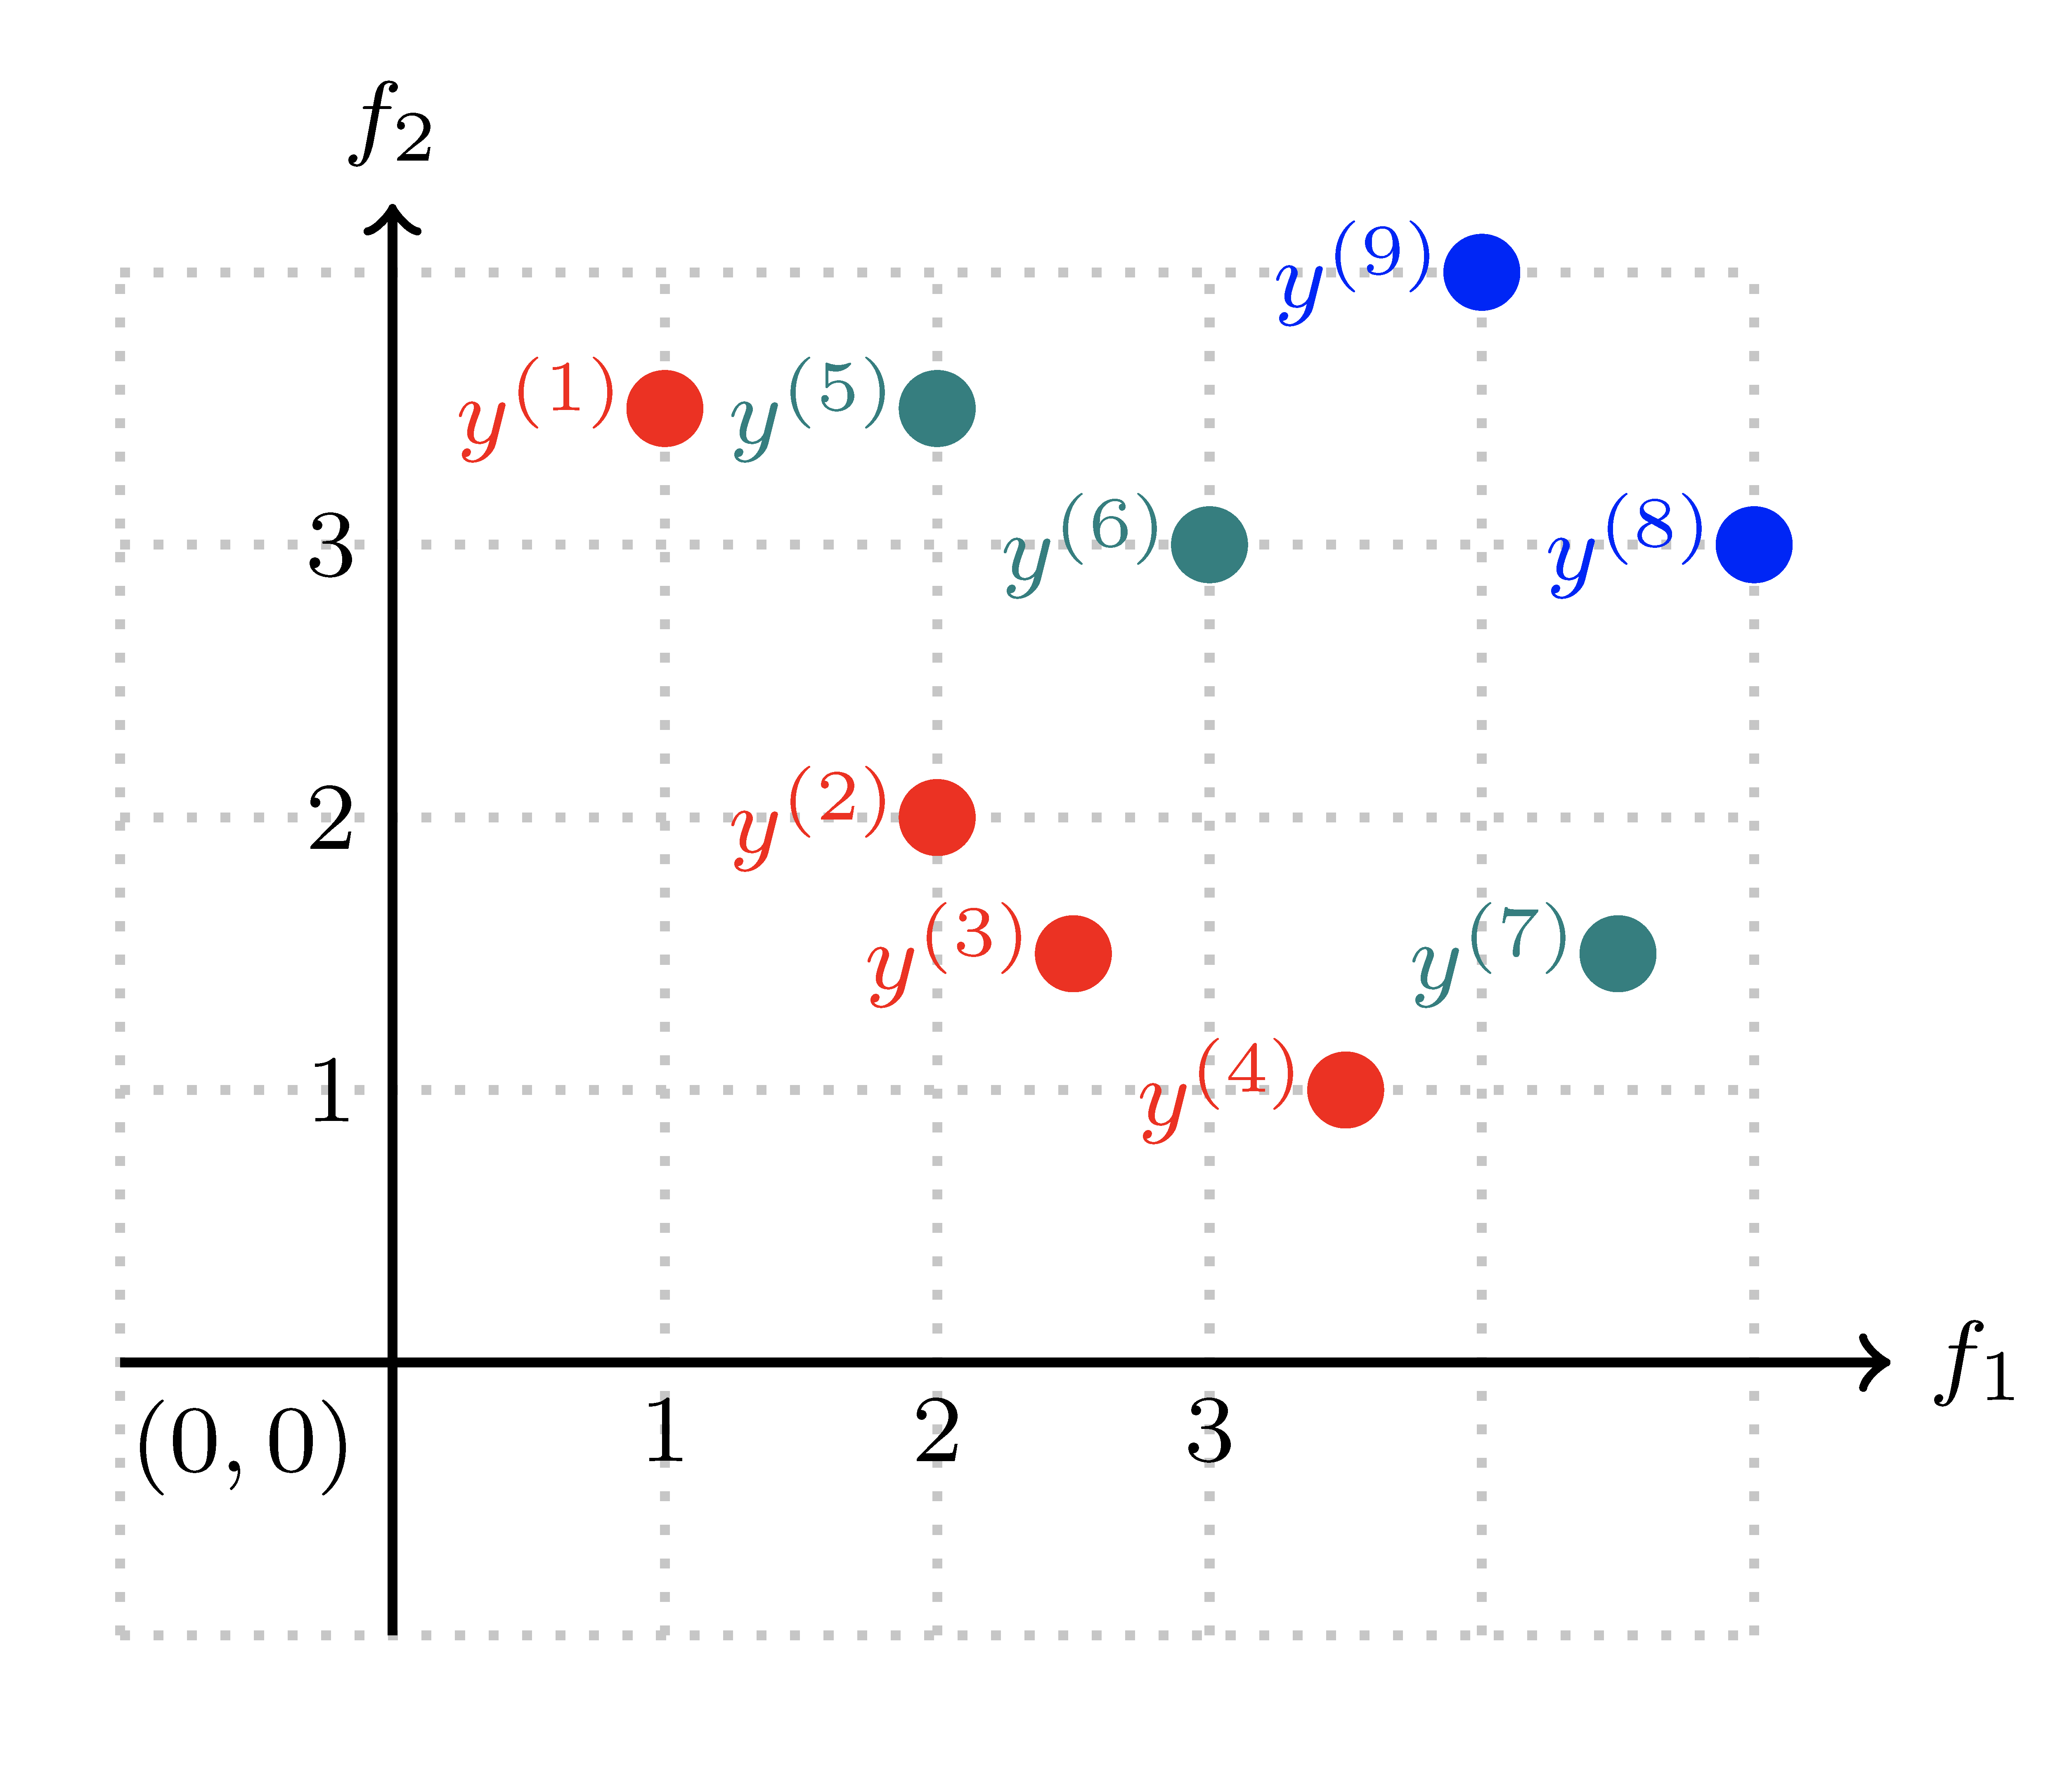

### Evaluating the Quality of a Pareto Front (Hypervolume)

Given a reference point $ r \in \mathbb R^M$, which we represent as a list of M `ObjectiveThreshold`s, one for each coordinate, the hypervolume (HV) of a Pareto set $\mathcal P = \{ f(x_i)\}_{i=1}^{|\mathcal P|}$ is the volume of the space dominated (superior in every one of our M objectives) by $\mathcal P$ and bounded from above by a point $ r$. The reference point should be set to be slightly worse (10% is reasonable) than the worst value of each objective that a decision maker would tolerate. In the figure below, the grey area is the hypervolume in this 2-objective problem.
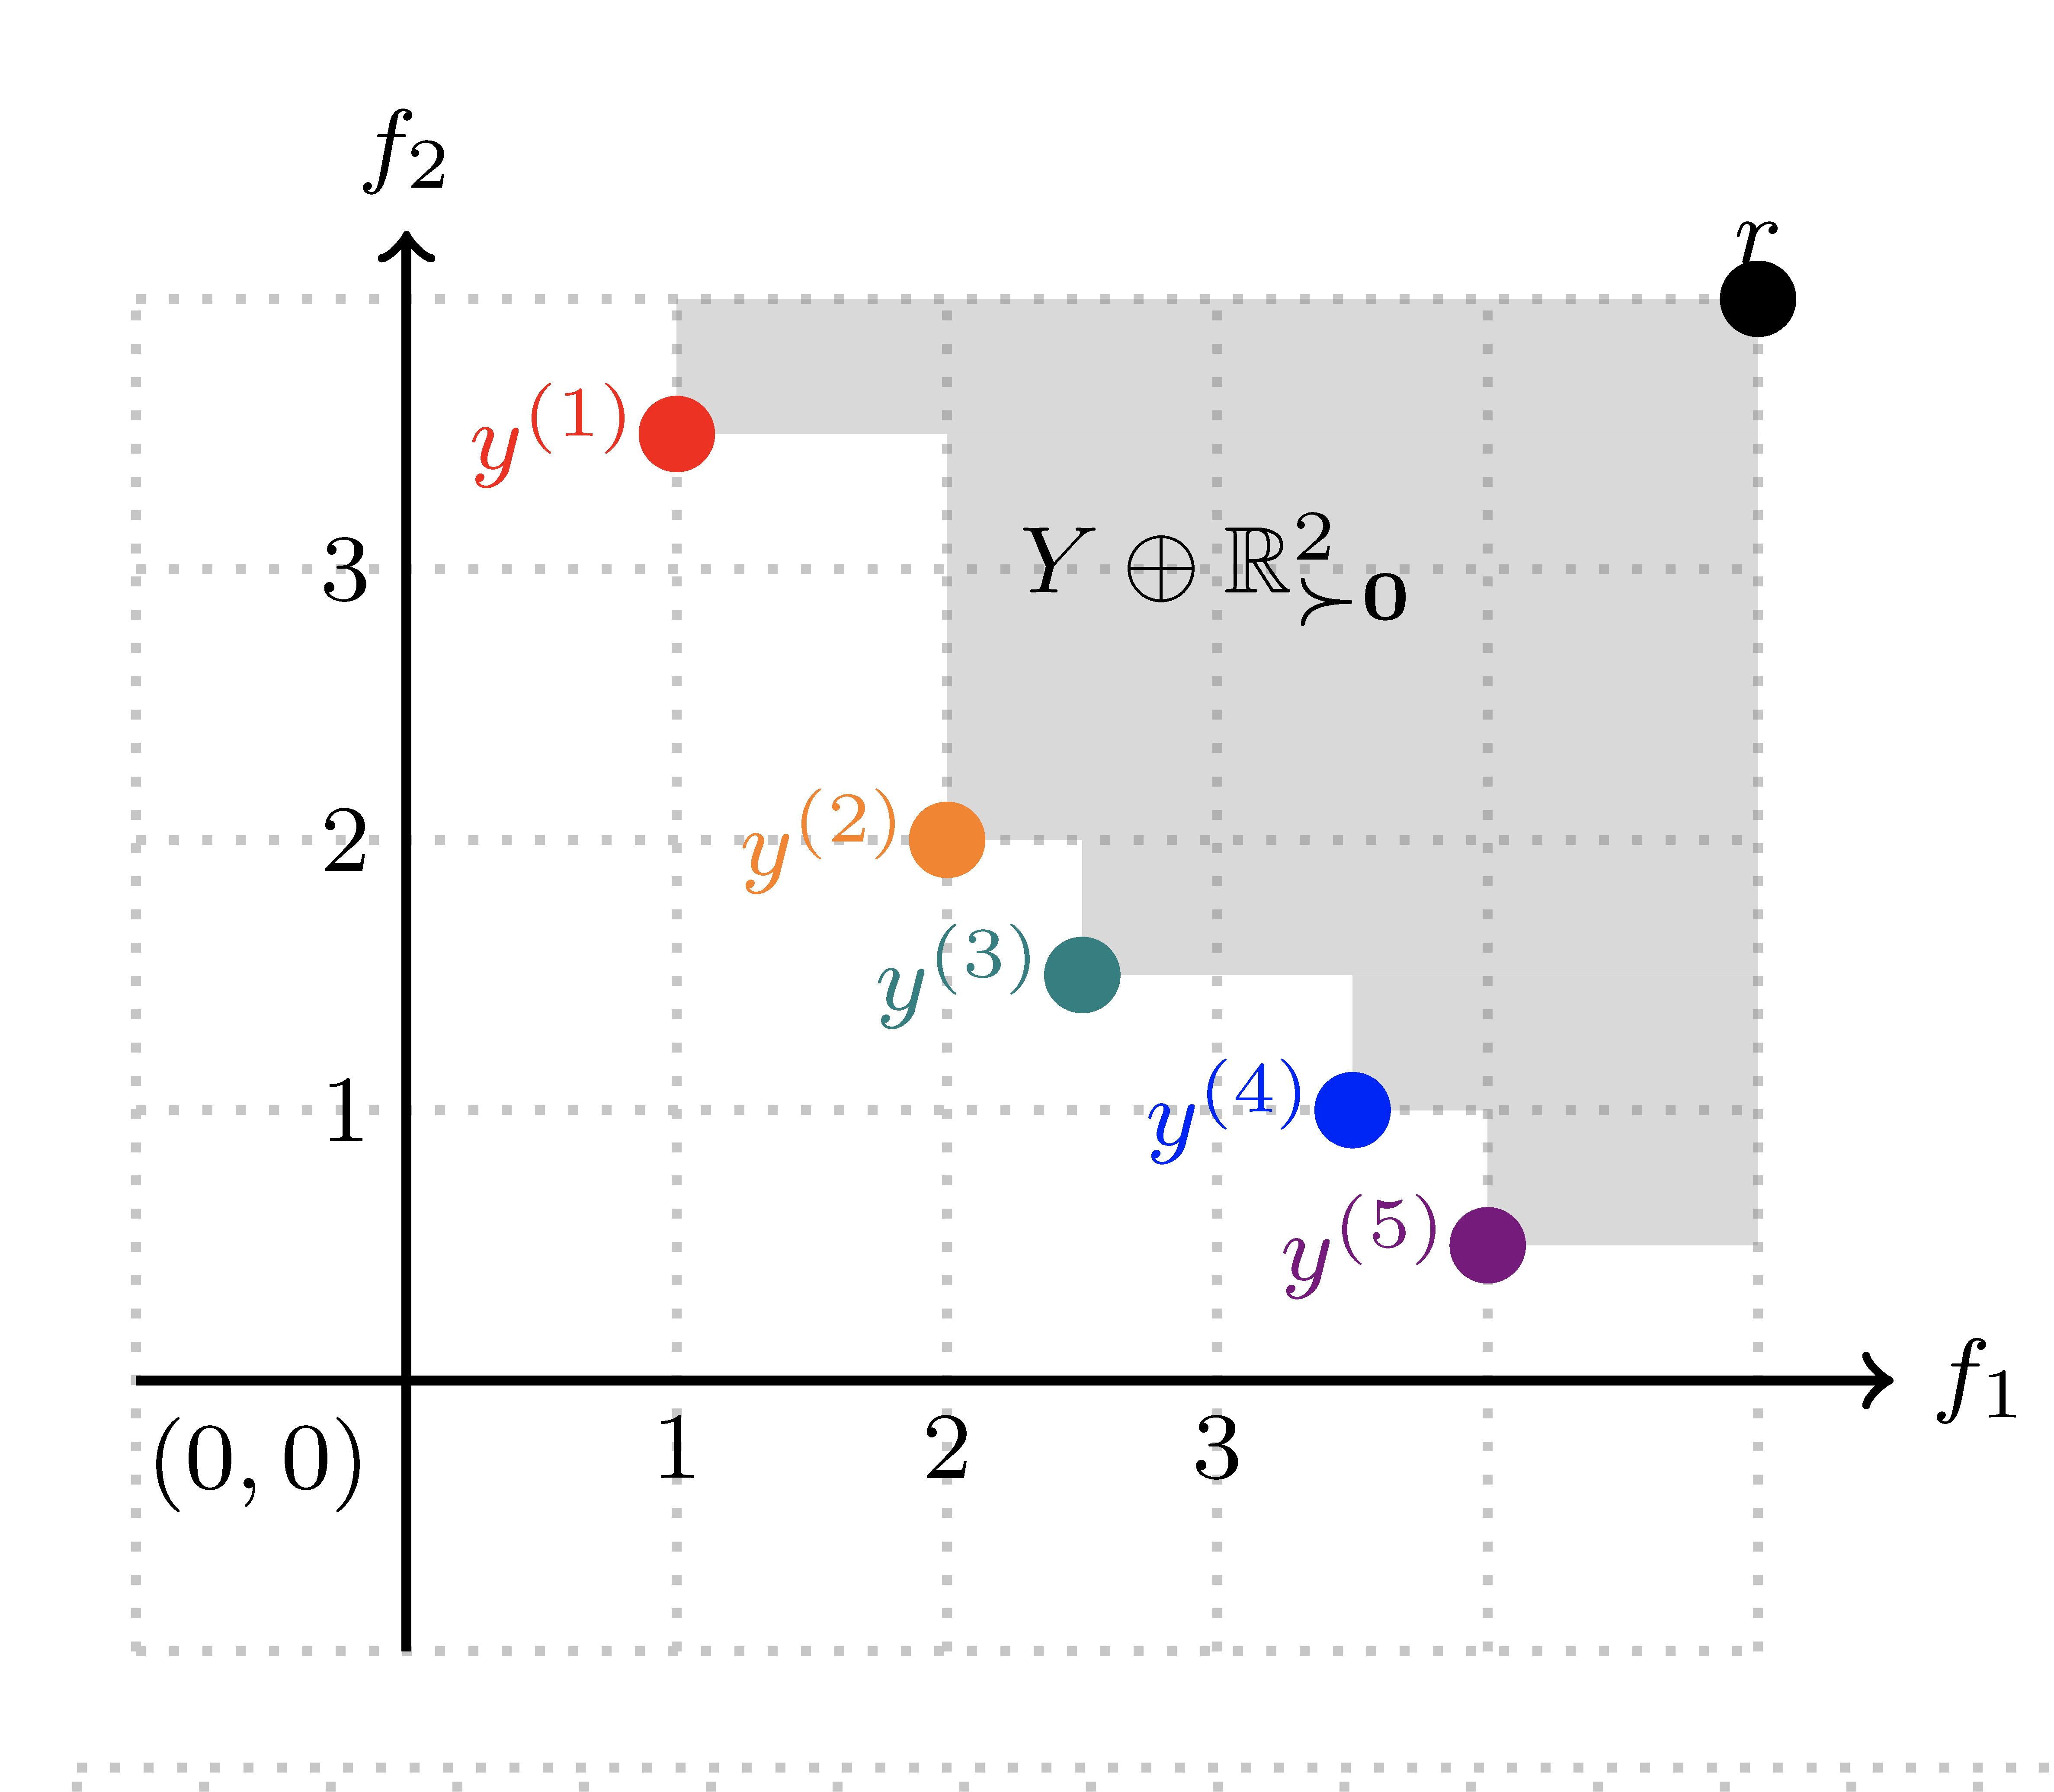

### Set Objective Thresholds to focus candidate generation in a region of interest

The below plots show three different sets of points generated by the qNEHVI [1] algorithm with different objective thresholds (aka reference points). Note that here we use absolute thresholds, but thresholds can also be relative to a status_quo arm.

The first plot shows the points without the `ObjectiveThreshold`s visible (they're set far below the origin of the graph).

The second shows the points generated with (-18, -6) as thresholds. The regions violating the thresholds are greyed out. Only the white region in the upper right exceeds both threshold, points in this region dominate the intersection of these thresholds (this intersection is the reference point). Only points in this region contribute to the hypervolume objective. A few exploration points are not in the valid region, but almost all the rest of the points are.

The third shows points generated with a very strict pair of thresholds, (-18, -2). Only the white region in the upper right exceeds both thresholds. Many points do not lie in the dominating region, but there are still more focused there than in the second examples.
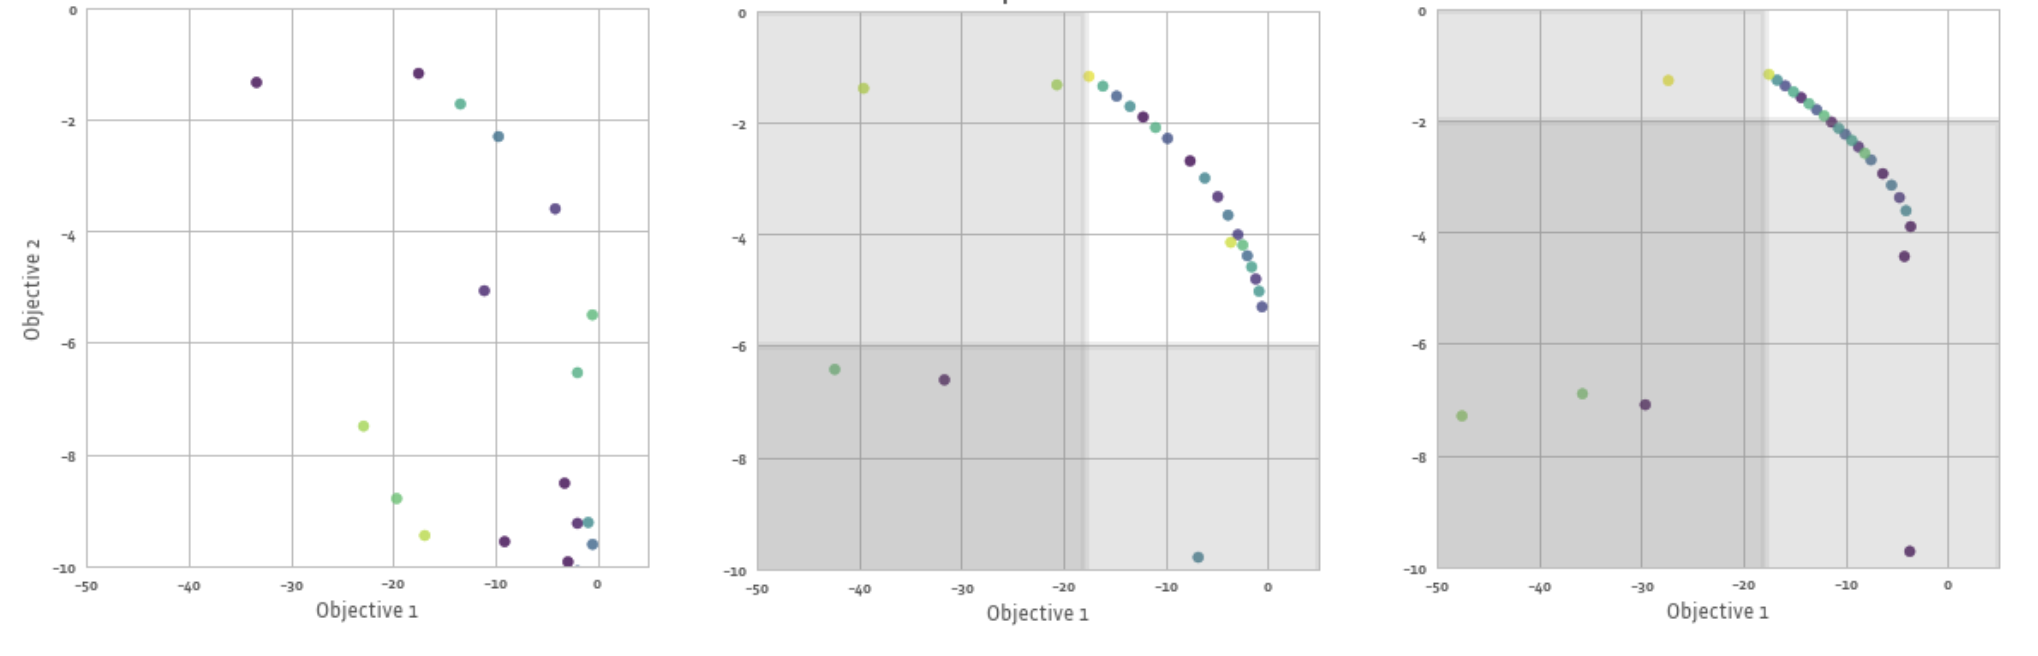

### Further Information
A deeper explanation of our the qNEHVI [1] and qNParEGO [2] algorithms this notebook explores can be found at 

[1] [S. Daulton, M. Balandat, and E. Bakshy. Parallel Bayesian Optimization of Multiple Noisy Objectives with Expected Hypervolume Improvement. Advances in Neural Information Processing Systems 34, 2021.](https://arxiv.org/abs/2105.08195)

[2] [S. Daulton, M. Balandat, and E. Bakshy. Differentiable Expected Hypervolume Improvement for Parallel Multi-Objective Bayesian Optimization. Advances in Neural Information Processing Systems 33, 2020.](https://arxiv.org/abs/2006.05078)

In addition, the underlying BoTorch implementation has a researcher-oriented tutorial at https://botorch.org/tutorials/multi_objective_bo.

## Setup

In [7]:
import numpy as np
import pandas as pd
from ax.core.data import Data
from ax.core.experiment import Experiment
from ax.core.metric import Metric
from ax.core.objective import MultiObjective, Objective
from ax.core.optimization_config import (
    MultiObjectiveOptimizationConfig,
    ObjectiveThreshold,
)

from ax.core.parameter import ParameterType, RangeParameter
from ax.core.search_space import SearchSpace
from ax.metrics.noisy_function import NoisyFunctionMetric

# Factory methods for creating multi-objective optimization modesl.
from ax.modelbridge.factory import get_MOO_EHVI, get_MOO_PAREGO

# Analysis utilities, including a method to evaluate hypervolumes
from ax.modelbridge.modelbridge_utils import observed_hypervolume
from ax.modelbridge.registry import Models
from ax.runners.synthetic import SyntheticRunner
from ax.service.utils.report_utils import exp_to_df

## Define experiment configurations

### Search Space

In [8]:
x1 = RangeParameter(name="x1", lower=0, upper=1, parameter_type=ParameterType.FLOAT)
x2 = RangeParameter(name="x2", lower=0, upper=1, parameter_type=ParameterType.FLOAT)

search_space = SearchSpace(parameters=[x1, x2])

### MultiObjectiveOptimizationConfig

To optimize multiple objective we must create a `MultiObjective` containing the metrics we'll optimize and `MultiObjectiveOptimizationConfig` (which contains `ObjectiveThreshold`s) instead of our more typical `Objective` and `OptimizationConfig`

We define `NoisyFunctionMetric`s to wrap our synthetic Branin-Currin problem's outputs. Add noise to see how robust our different optimization algorithms are.

In [9]:
class MetricA(NoisyFunctionMetric):
    def f(self, x: np.ndarray) -> float:
        return float(branin_currin(torch.tensor(x))[0])


class MetricB(NoisyFunctionMetric):
    def f(self, x: np.ndarray) -> float:
        return float(branin_currin(torch.tensor(x))[1])


metric_a = MetricA("a", ["x1", "x2"], noise_sd=0.0, lower_is_better=False)
metric_b = MetricB("b", ["x1", "x2"], noise_sd=0.0, lower_is_better=False)

In [10]:
mo = MultiObjective(
    objectives=[Objective(metric=metric_a), Objective(metric=metric_b)],
)

In [11]:
objective_thresholds = [
    ObjectiveThreshold(metric=metric, bound=val, relative=False)
    for metric, val in zip(mo.metrics, branin_currin.ref_point)
]

In [12]:
optimization_config = MultiObjectiveOptimizationConfig(
    objective=mo,
    objective_thresholds=objective_thresholds,
)

## Define experiment creation utilities

These construct our experiment, then initialize with Sobol points before we fit a Gaussian Process model to those initial points.

In [13]:
# Reasonable defaults for number of quasi-random initialization points and for subsequent model-generated trials.
N_INIT = 6
N_BATCH = 25

In [14]:
def build_experiment():
    experiment = Experiment(
        name="pareto_experiment",
        search_space=search_space,
        optimization_config=optimization_config,
        runner=SyntheticRunner(),
    )
    return experiment

In [15]:
## Initialize with Sobol samples
def initialize_experiment(experiment):
    sobol = Models.SOBOL(search_space=experiment.search_space, seed=1234)
    for _ in range(N_INIT):
        experiment.new_trial(sobol.gen(1)).run()
    return experiment.fetch_data()

# Sobol
We use quasirandom points as a fast baseline for evaluating the quality of our multi-objective optimization algorithms.

In [16]:
sobol_experiment = build_experiment()
sobol_data = initialize_experiment(sobol_experiment)

In [17]:
sobol_model = Models.SOBOL(
    experiment=sobol_experiment,
    data=sobol_data,
)
sobol_hv_list = []
for i in range(N_BATCH):
    generator_run = sobol_model.gen(1)
    trial = sobol_experiment.new_trial(generator_run=generator_run)
    trial.run()
    exp_df = exp_to_df(sobol_experiment)
    outcomes = np.array(exp_df[["a", "b"]], dtype=np.double)
    # Fit a GP-based model in order to calculate hypervolume.
    # We will not use this model to generate new points.
    dummy_model = Models.BOTORCH_MODULAR(
        experiment=sobol_experiment,
        data=sobol_experiment.fetch_data(),
    )
    try:
        hv = observed_hypervolume(modelbridge=dummy_model)
    except:
        hv = 0
        print("Failed to compute hv")
    sobol_hv_list.append(hv)
    print(f"Iteration: {i}, HV: {hv}")

sobol_outcomes = np.array(exp_to_df(sobol_experiment)[["a", "b"]], dtype=np.double)

/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 05-02 22:36:08] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 05-02 22:36:08] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 05-02 22:36:08] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 0, HV: 0.0
Iteration: 1, HV: 0.0


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 05-02 22:36:08] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 05-02 22:36:09] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 2, HV: 0.0
Iteration: 3, HV: 0.0


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 05-02 22:36:09] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 05-02 22:36:09] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 4, HV: 0.0
Iteration: 5, HV: 0.0


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



[WARNING 05-02 22:36:09] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 6, HV: 0.0


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 05-02 22:36:09] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 7, HV: 0.0


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



[WARNING 05-02 22:36:10] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 8, HV: 0.0


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 05-02 22:36:10] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 9, HV: 0.0


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 05-02 22:36:10] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 10, HV: 0.0


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 05-02 22:36:10] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 11, HV: 0.0


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 05-02 22:36:11] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 12, HV: 0.0


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 05-02 22:36:11] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 13, HV: 0.0


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 05-02 22:36:11] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 14, HV: 0.0


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 05-02 22:36:12] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 15, HV: 0.0


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 05-02 22:36:12] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 16, HV: 0.0


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 05-02 22:36:12] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 17, HV: 7.126465505655923


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 05-02 22:36:12] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 18, HV: 7.126465505655923


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 05-02 22:36:13] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 19, HV: 7.126465505655923


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 05-02 22:36:13] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 20, HV: 7.126465505655923


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 05-02 22:36:14] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 21, HV: 7.126465505655923


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 05-02 22:36:14] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 22, HV: 7.126465505655923


/tmp/tmp.J4Ip05By14/Ax-main/ax/core/data.py:286: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[WARNING 05-02 22:36:14] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 23, HV: 7.126465505655923


[WARNING 05-02 22:36:15] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 24, HV: 7.126465505655923


## qNEHVI
Noisy Expected Hypervolume Improvement. This is our current recommended algorithm for multi-objective optimization.

In [18]:
ehvi_experiment = build_experiment()
ehvi_data = initialize_experiment(ehvi_experiment)

In [19]:
ehvi_hv_list = []
ehvi_model = None
for i in range(N_BATCH):
    ehvi_model = Models.BOTORCH_MODULAR(
        experiment=ehvi_experiment,
        data=ehvi_data,
    )
    generator_run = ehvi_model.gen(1)
    trial = ehvi_experiment.new_trial(generator_run=generator_run)
    trial.run()
    ehvi_data = Data.from_multiple_data([ehvi_data, trial.fetch_data()])

    exp_df = exp_to_df(ehvi_experiment)
    outcomes = np.array(exp_df[["a", "b"]], dtype=np.double)
    try:
        hv = observed_hypervolume(modelbridge=ehvi_model)
    except:
        hv = 0
        print("Failed to compute hv")
    ehvi_hv_list.append(hv)
    print(f"Iteration: {i}, HV: {hv}")

ehvi_outcomes = np.array(exp_to_df(ehvi_experiment)[["a", "b"]], dtype=np.double)

[WARNING 05-02 22:36:16] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 0, HV: 0.0


[WARNING 05-02 22:36:17] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 1, HV: 0.0


[WARNING 05-02 22:36:17] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 2, HV: 0.0


[WARNING 05-02 22:36:18] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 3, HV: 0.0


[WARNING 05-02 22:36:18] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 4, HV: 29.5232278432437


[WARNING 05-02 22:36:19] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 5, HV: 42.402756933308616


[WARNING 05-02 22:36:20] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 6, HV: 47.14874050203988


[WARNING 05-02 22:36:21] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 7, HV: 49.89545829340218


[WARNING 05-02 22:36:23] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 8, HV: 50.17772247272863


[WARNING 05-02 22:36:24] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 9, HV: 51.748934364643176


[WARNING 05-02 22:36:26] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 10, HV: 53.00764596417966


[WARNING 05-02 22:36:27] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 11, HV: 54.00227379533954


[WARNING 05-02 22:36:30] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 12, HV: 54.00227379533954


[WARNING 05-02 22:36:32] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 13, HV: 54.00227379533954


[WARNING 05-02 22:36:34] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 14, HV: 54.406850466642645


[WARNING 05-02 22:36:39] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 15, HV: 54.92969574205242


[WARNING 05-02 22:36:41] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 16, HV: 55.277196133370566


[WARNING 05-02 22:36:44] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 17, HV: 55.62925119436597


[WARNING 05-02 22:36:47] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 18, HV: 55.943867471613444


[WARNING 05-02 22:36:51] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 19, HV: 56.24244670094765


[WARNING 05-02 22:36:55] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 20, HV: 56.42066488133081


[WARNING 05-02 22:36:58] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 21, HV: 56.66119819446318


[WARNING 05-02 22:37:00] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 22, HV: 56.72637331030748


[WARNING 05-02 22:37:04] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 23, HV: 56.966319143492335


[WARNING 05-02 22:37:09] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


[WARNING 05-02 22:37:09] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 24, HV: 57.08331721841996


## Plot qNEHVI Pareto Frontier based on model posterior 

The plotted points are samples from the fitted model's posterior, not observed samples.

In [20]:
frontier = compute_posterior_pareto_frontier(
    experiment=ehvi_experiment,
    data=ehvi_experiment.fetch_data(),
    primary_objective=metric_b,
    secondary_objective=metric_a,
    absolute_metrics=["a", "b"],
    num_points=20,
)

render(plot_pareto_frontier(frontier, CI_level=0.90))

## qNParEGO
This is a good alternative algorithm for multi-objective optimization when qNEHVI runs too slowly.

In [21]:
parego_experiment = build_experiment()
parego_data = initialize_experiment(parego_experiment)

In [22]:
parego_hv_list = []
parego_model = None
for i in range(N_BATCH):
    parego_model = get_MOO_PAREGO(
        experiment=parego_experiment,
        data=parego_data,
    )
    generator_run = parego_model.gen(1)
    trial = parego_experiment.new_trial(generator_run=generator_run)
    trial.run()
    parego_data = Data.from_multiple_data([parego_data, trial.fetch_data()])

    exp_df = exp_to_df(parego_experiment)
    outcomes = np.array(exp_df[["a", "b"]], dtype=np.double)
    try:
        hv = observed_hypervolume(modelbridge=parego_model)
    except:
        hv = 0
        print("Failed to compute hv")
    parego_hv_list.append(hv)
    print(f"Iteration: {i}, HV: {hv}")

parego_outcomes = np.array(exp_to_df(parego_experiment)[["a", "b"]], dtype=np.double)

[WARNING 05-02 22:37:28] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 0, HV: 0.0


[WARNING 05-02 22:37:28] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 1, HV: 0.0


[WARNING 05-02 22:37:29] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 2, HV: 0.0


[WARNING 05-02 22:37:31] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 3, HV: 0.0


[WARNING 05-02 22:37:32] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 4, HV: 0.0


[WARNING 05-02 22:37:34] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 5, HV: 0.0


[WARNING 05-02 22:37:35] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 6, HV: 0.0


[WARNING 05-02 22:37:37] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 7, HV: 0.0


[WARNING 05-02 22:37:38] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 8, HV: 0.0


/opt/hostedtoolcache/Python/3.10.14/x64/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[WARNING 05-02 22:37:38] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 9, HV: 2.369795709893773


[WARNING 05-02 22:37:41] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 10, HV: 36.271601900221036


[WARNING 05-02 22:37:43] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 11, HV: 38.10389515070386


[WARNING 05-02 22:37:45] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 12, HV: 42.59532013582462


[WARNING 05-02 22:37:48] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 13, HV: 42.905571997036596


[WARNING 05-02 22:37:51] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 14, HV: 42.91551010105619


[WARNING 05-02 22:37:54] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 15, HV: 43.25489339616676


/opt/hostedtoolcache/Python/3.10.14/x64/lib/python3.10/site-packages/botorch/optim/optimize.py:588: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 4 and message Inequality constraints incompatible.')]
Trying again with a new set of initial conditions.



[WARNING 05-02 22:37:58] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 16, HV: 43.29697060693908


[WARNING 05-02 22:38:00] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 17, HV: 43.48052575073011


/opt/hostedtoolcache/Python/3.10.14/x64/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[WARNING 05-02 22:38:03] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 18, HV: 43.49057823303443


[WARNING 05-02 22:38:06] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 19, HV: 43.50561374384218


[WARNING 05-02 22:38:10] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 20, HV: 43.65392650842006


[WARNING 05-02 22:38:12] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 21, HV: 43.661419546071485


/opt/hostedtoolcache/Python/3.10.14/x64/lib/python3.10/site-packages/botorch/optim/optimize.py:588: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 4 and message Inequality constraints incompatible.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal')]
Trying again with a new set of initial conditions.



/opt/hostedtoolcache/Python/3.10.14/x64/lib/python3.10/site-packages/botorch/optim/optimize.py:588: RuntimeWarning:

Optimization failed on the second try, after generating a new set of initial conditions.

/opt/hostedtoolcache/Python/3.10.14/x64/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[WARNING 05-02 22:38:13] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 22, HV: 43.80492199496147


[WARNING 05-02 22:38:17] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 23, HV: 43.80492199496147


[WARNING 05-02 22:38:18] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


[WARNING 05-02 22:38:18] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


Iteration: 24, HV: 43.80852537852891


## Plot qNParEGO Pareto Frontier based on model posterior 

The plotted points are samples from the fitted model's posterior, not observed samples.

In [23]:
frontier = compute_posterior_pareto_frontier(
    experiment=parego_experiment,
    data=parego_experiment.fetch_data(),
    primary_objective=metric_b,
    secondary_objective=metric_a,
    absolute_metrics=["a", "b"],
    num_points=20,
)

render(plot_pareto_frontier(frontier, CI_level=0.90))

## Plot empirical data

#### Plot observed hypervolume, with color representing the iteration that a point was generated on.

To examine optimization process from another perspective, we plot the collected observations under each algorithm where the color corresponds to the BO iteration at which the point was collected. The plot on the right for $q$NEHVI shows that the $q$NEHVI quickly identifies the Pareto frontier and most of its evaluations are very close to the Pareto frontier. $q$NParEGO also identifies has many observations close to the Pareto frontier, but relies on optimizing random scalarizations, which is a less principled way of optimizing the Pareto front compared to $q$NEHVI, which explicitly attempts focuses on improving the Pareto front. Sobol generates random points and has few points close to the Pareto front.

Text(0.5, 1.0, 'Iteration')

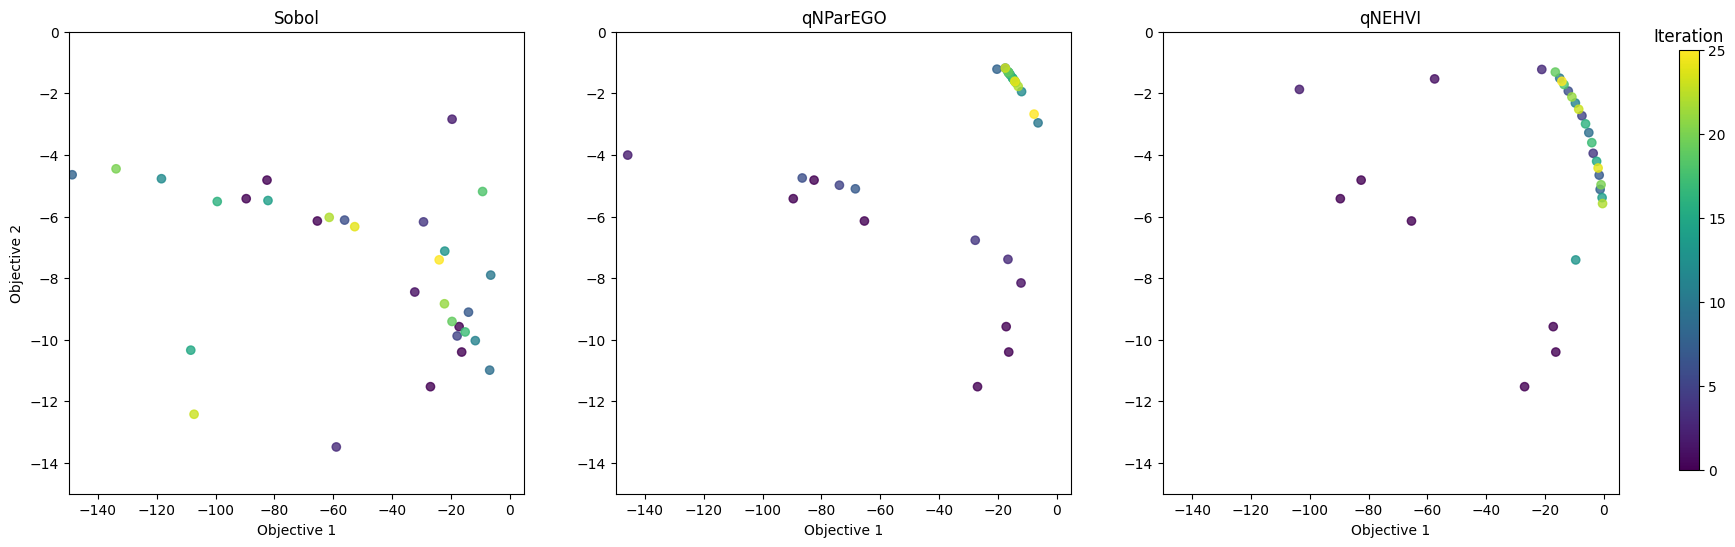

In [24]:
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable

%matplotlib inline


fig, axes = plt.subplots(1, 3, figsize=(20, 6))
algos = ["Sobol", "qNParEGO", "qNEHVI"]
outcomes_list = [sobol_outcomes, parego_outcomes, ehvi_outcomes]
cm = matplotlib.colormaps["viridis"]
BATCH_SIZE = 1

n_results = N_BATCH * BATCH_SIZE + N_INIT
batch_number = torch.cat(
    [
        torch.zeros(N_INIT),
        torch.arange(1, N_BATCH + 1).repeat(BATCH_SIZE, 1).t().reshape(-1),
    ]
).numpy()
for i, train_obj in enumerate(outcomes_list):
    x = i
    sc = axes[x].scatter(
        train_obj[:n_results, 0],
        train_obj[:n_results, 1],
        c=batch_number[:n_results],
        alpha=0.8,
    )
    axes[x].set_title(algos[i])
    axes[x].set_xlabel("Objective 1")
    axes[x].set_xlim(-150, 5)
    axes[x].set_ylim(-15, 0)
axes[0].set_ylabel("Objective 2")
norm = plt.Normalize(batch_number.min(), batch_number.max())
sm = ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration")

# Hypervolume statistics
The hypervolume of the space dominated by points that dominate the reference point.

#### Plot the results
The plot below shows a common metric of multi-objective optimization performance when the true Pareto frontier is known:  the log difference between the hypervolume of the true Pareto front and the hypervolume of the approximate Pareto front identified by each algorithm. The log hypervolume difference is plotted at each step of the optimization for each of the algorithms.

The plot show that $q$NEHVI vastly outperforms $q$NParEGO which outperforms the Sobol baseline.

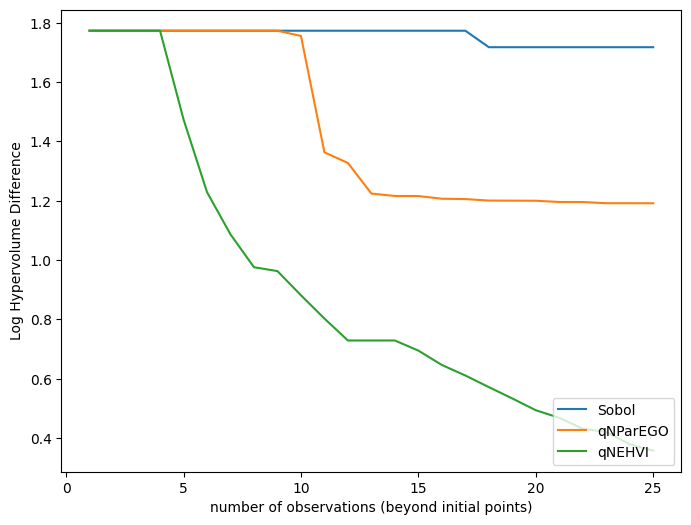

In [25]:
iters = np.arange(1, N_BATCH + 1)
log_hv_difference_sobol = np.log10(branin_currin.max_hv - np.asarray(sobol_hv_list))[
    : N_BATCH + 1
]
log_hv_difference_parego = np.log10(branin_currin.max_hv - np.asarray(parego_hv_list))[
    : N_BATCH + 1
]
log_hv_difference_ehvi = np.log10(branin_currin.max_hv - np.asarray(ehvi_hv_list))[
    : N_BATCH + 1
]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(iters, log_hv_difference_sobol, label="Sobol", linewidth=1.5)
ax.plot(iters, log_hv_difference_parego, label="qNParEGO", linewidth=1.5)
ax.plot(iters, log_hv_difference_ehvi, label="qNEHVI", linewidth=1.5)
ax.set(
    xlabel="number of observations (beyond initial points)",
    ylabel="Log Hypervolume Difference",
)
ax.legend(loc="lower right")